## Node2Vec ##

Nous allons utiliser l'algorithme node2vec pour représenter le graph des relations deezer de la Croatie différemment. Nous utiliserons ensuite des méthodes de clustering pour effectuer de la détection de communauté et pouvoir les comparer aux méthodes traditionnelles sans Machine learning. 

In [2]:
import networkx as nx
import csv
import pandas as pd
from pyvis.network import Network
from node2vec import Node2Vec
import random
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score

Nous commençons par faire tourner node2vec sur notre dataset pour créer des embeddings que nous analyserons par la suite 

In [2]:
# Read the CSV file
df = pd.read_csv('deezer_clean_data/HR_edges.csv')

# Create a graph
G = nx.from_pandas_edgelist(df, source='node_1', target='node_2')

# Get a sample of 10,000 nodes from G
random.seed(42)
sample_nodes = random.sample(list(G.nodes()), 10000)

# Create a new graph with the sample nodes
G = G.subgraph(sample_nodes)

# Print the graph summary
print(G)

Graph with 10000 nodes and 16022 edges


Initialisation de Node2Vec avec les hyperparamètres du papier original. Après quelques tentatives nous nous sommes rendu compte qu'ils maximisaient les performances. 

In [8]:

node2vec = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=4) 
    
# Generate walks
walks = node2vec.walks

# Train Node2Vec model
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 10000/10000 [00:04<00:00, 2246.69it/s]


In [9]:
model.wv.save_word2vec_format("HR_embeddings.emb")

# Analyse 

Utilisons ces embeddings pour mener quelques analyses et essayer des repérer des clusters.

In [3]:
embeddings = KeyedVectors.load_word2vec_format("HR_embeddings_10000.emb")
embeddings_list = np.array(list(embeddings.vectors))

keys = list(embeddings.key_to_index.keys())

Commençons par afficher la répartition des ces embeddings en 2 dimensions en utilisant une PCA et T-SNE.

In [4]:
#Une fonction pour afficher les représentation en dimensions réduites

def plot_scatter(embeddings, labels, title):
    
    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

#On représente les embeddings en 2D

n_components = 2

C:\Users\arnoh\AppData\Local\Temp\ipykernel_65824\2077088269.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=10)


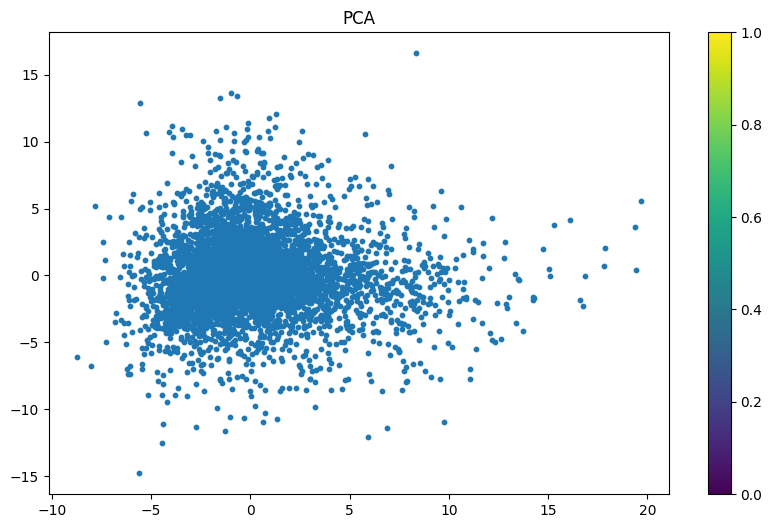

In [35]:
#On fait tourner la PCA

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embeddings_list)

#On affiche les embeddings en 2D

plot_scatter(pca_result, labels=None, title='PCA')



La PCA ne nous permet pas de visualiser grand chose en l'état, probablement que les deux dimensions sur 64 ne sont pas suffisantes pour capturer les réelles sources de variance des données. 

C:\Users\arnoh\AppData\Local\Temp\ipykernel_65824\2077088269.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=10)


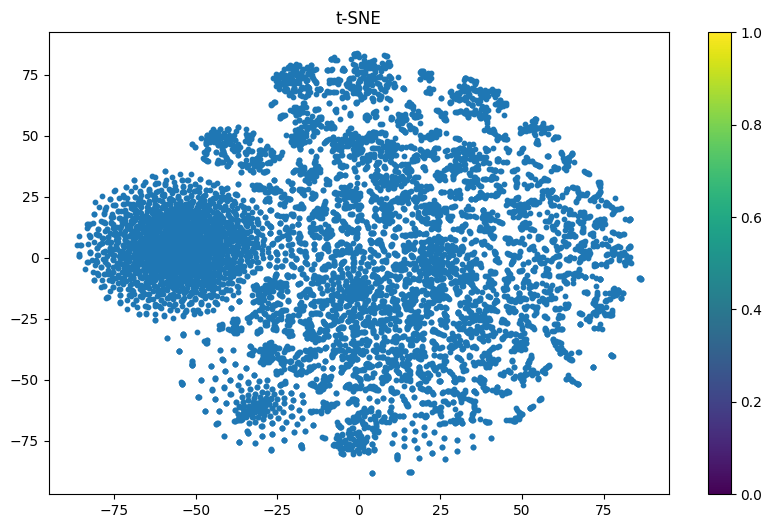

In [36]:
#We compute the t-SNE representation of the embeddings

tsne = TSNE(n_components=n_components, random_state=42)
tsne_result = tsne.fit_transform(embeddings_list)

#We plot the t-SNE representation of the embeddings

plot_scatter(tsne_result, labels=None, title='t-SNE')

On perçoit ce qui pourrait s'apparenter à des cluster dans cette représentation. Essayons maintenant d'en trouver dans la représentation générée par node2vec. Commençons par déterminer le nombre de clusters optimal en utilisant le coefficient de silhouette. Nous utiliserons deux algorithmes de clustering : K-means et DBSCAN. 

In [29]:


# Define the range of cluster numbers to try
min_clusters = 2
max_clusters = 20

# Initialize variables to store the best cluster number and silhouette score
best_cluster_number = 0
best_silhouette_score = -1

# Iterate over the range of cluster numbers
for n_clusters in range(min_clusters, max_clusters+1):
    # Perform clustering using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_list)
    print(cluster_labels)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(embeddings_list, cluster_labels)

    print("Number of clusters:", n_clusters, "\tSilhouette score:", silhouette_avg)
    
    # Check if the current silhouette score is better than the previous best score
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_cluster_number = n_clusters
        final_cluster_labels_KMeans = cluster_labels

    

# Print the optimal cluster number and silhouette score
print("Optimal number of clusters:", best_cluster_number)
print("Silhouette score:", best_silhouette_score)
print(final_cluster_labels_KMeans)

#Best silhouette score so far for two clusters : 0,34


c:\Users\arnoh\anaconda3\envs\con_rais\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 1 0 ... 1 1 1]
Number of clusters: 2 	Silhouette score: 0.3383573


c:\Users\arnoh\anaconda3\envs\con_rais\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[2 1 2 ... 1 1 1]
Number of clusters: 3 	Silhouette score: 0.30305326
Optimal number of clusters: 2
Silhouette score: 0.3383573
[0 1 0 ... 1 1 1]


Nous obtenons le score de silhouette le plus élevé pour 2 clusters ce qui n'est pas très convaincant. Nous obtenons tout de même un score intéressant de 0,22 (plus élevé que les autres scores à proximité) pour 15 clusters. 

In [ ]:
#Let's see if we can do something better with DBSCAN
#We will try make a grid search on eps and min_samples

# Define the range of eps values to try

eps_values = [0.1, 0.5, 1, 2, 5, 10, 15, 20 ]

# Define the range of min_samples values to try

min_samples_values = [2,5, 8, 10]

#We evaluate the quality of the hyperparameters using the silhouette score

best_silhouette_score = -1

# Initialize variables to store the best hyperparameters

best_eps = 0
best_min_samples = 0

# Iterate over the range of eps values

for eps in eps_values:
    # Iterate over the range of min_samples values
    for min_samples in min_samples_values:
        # Perform clustering using DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(embeddings_list)

        print(cluster_labels)
        
        # Calculate the silhouette score
        silhouette_avg = silhouette_score(embeddings_list, cluster_labels)

        print("eps:", eps, "min_samples:", min_samples, "silhouette score:", silhouette_avg)
        
        # Check if the current silhouette score is better than the previous best score
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_min_samples = min_samples
            final_cluster_labels_DBSCAN = list(i+1 for i in cluster_labels)

# Print the optimal hyperparameters and silhouette score
print("Optimal eps:", best_eps)
print("Optimal min_samples:", best_min_samples)
print("Silhouette score:", best_silhouette_score)

Nous obtenons des scores de silhouette bas avec DBSCAN mais à nouveau le meilleur score de silhouette est obtenu pour 2 clusters. 

Représentons les clusters dans le plan avec une PCA et T-SNE. 

873
9127


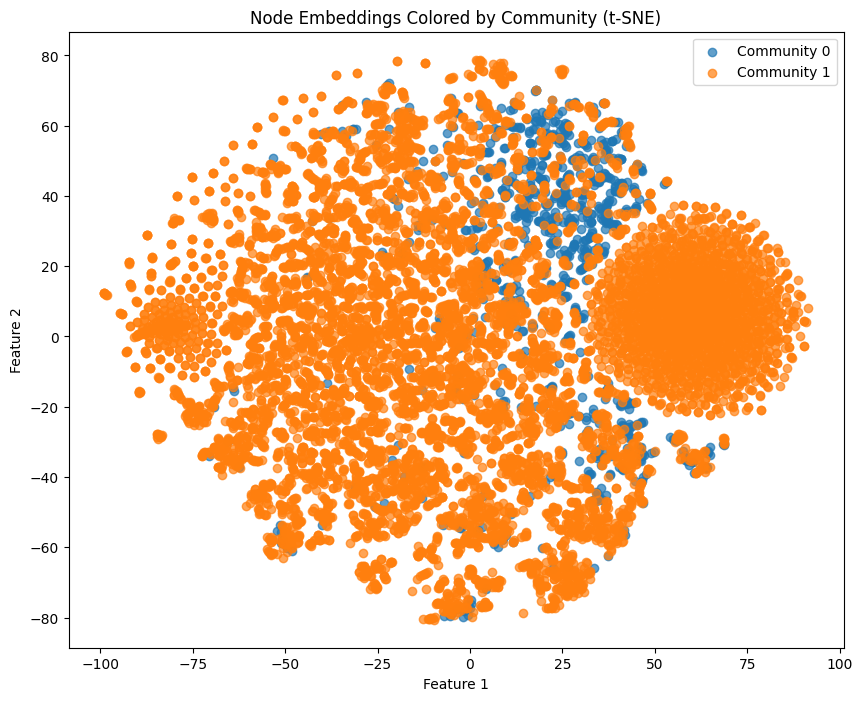

In [60]:


tsne = TSNE(n_components=2, random_state=7)
embeddings_2d = tsne.fit_transform(embeddings_list)

num_clusters = len(set(final_cluster_labels_KMeans))

# Plot the nodes with colors representing their community assignments
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    indices = np.where(final_cluster_labels_KMeans == i)[0]
    print(len(indices))
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Community {i}", alpha=0.7)

plt.title('Node Embeddings Colored by Community (t-SNE)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Je ne suis pas sûr que cette représentation nous apporte quoi que ce soit parce que T-SNE ne capture pas nécessairement les bons aspects des vecteurs donnés et ne permet pas de correctement représenter la sépération qui est faite par l'algorithme de clustering. Utilisons plutôt le score de modularité pour comparer les résulats avec ML aux résulats sans.

873
9127


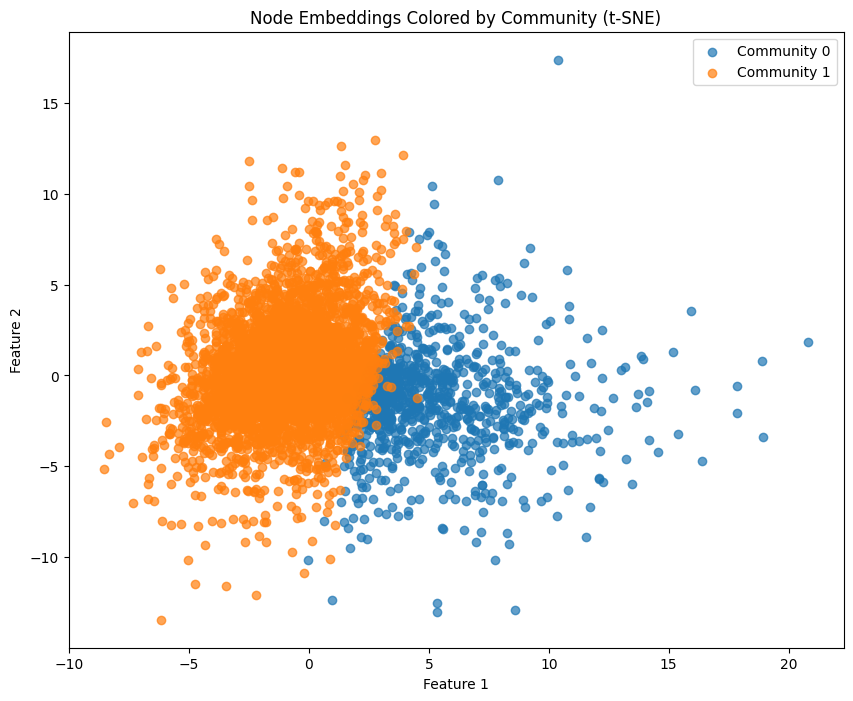

In [30]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_list)

num_clusters = len(set(final_cluster_labels_KMeans))



# Plot the nodes with colors representing their community assignments
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    indices = np.where(final_cluster_labels_KMeans == i)[0]
    print(len(indices))
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f"Community {i}", alpha=0.7)

plt.title('Node Embeddings Colored by Community (t-SNE)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

On ne repère pas de séparation cohèrente sur aucune des deux représentations ce qui laisse penser que le clustering n'a pas été efficace ou que la PCA et T-SNE ne capturent pas correctement la variance des données.  

In [4]:
#A function to create partition with clusters

def create_modularity_partition(G, clusters, n_clusters):
    
    partition = []
    for i in range(n_clusters):
        partition.append(set()) 
        for j in range(len(clusters)) :
            if clusters[j] == i :
                partition[i].add(int(keys[j]))

    partition_generator = (community for community in partition)

    return partition_generator


In [31]:
#Calculons la modularité pour les clusters obtenus avec ces deux algorithmes qui cherchent à maximiser la silhouette score

# Calculate the modularity of the KMeans clustering
modularity_KMeans = nx.algorithms.community.modularity(G, create_modularity_partition(G, final_cluster_labels_KMeans, 2))

# Calculate the modularity of the DBSCAN clustering
modularity_DBSCAN = nx.algorithms.community.modularity(G, create_modularity_partition(G, final_cluster_labels_DBSCAN, 2))

# Print the modularity of the KMeans and DBSCAN clusterings
print("Modularity KMeans:", modularity_KMeans)
print("Modularity DBSCAN:", modularity_DBSCAN)

873
9127
Modularity KMeans: 0.19154345391177505
Modularity DBSCAN: 0.002693681034414564


Comme présentit avec les représentation, les scores de modularity sont mauvais. 

In [ ]:
# Define the range of cluster numbers to try
min_clusters = 20
max_clusters = 40

# Initialize variables to store the best cluster number and modularity score
best_cluster_number = 0
best_modularity_score = -1

# Iterate over the range of cluster numbers
for n_clusters in range(min_clusters, max_clusters+1):
    # Perform clustering using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_list)
    
    # Calculate the modularity score
    modularity = nx.community.modularity(G, create_modularity_partition(G, cluster_labels, n_clusters))

    # print("Number of clusters:", n_clusters, "\tModularity score:", modularity)
    
    # Check if the current modularity score is better than the previous best score
    if modularity > best_modularity_score:
        best_modularity_score = modularity
        best_cluster_number = n_clusters

# Print the optimal cluster number and modularity score
print("Optimal number of clusters:", best_cluster_number)
print("Modularity score:", best_modularity_score)


La modularity maximale est atteinte avec 32 clusters en utilisant K-means avec un score de 0.56 environ. Essayons la même chose avec DBSCAN. 

In [ ]:
#Let's see if we can do something better with DBSCAN
#We will try make a grid search on eps and min_samples

# Define the range of eps values to try

eps_values = [0.1, 0.5, 1, 2, 5, 10, 12, 17, 20 ]

# Define the range of min_samples values to try

min_samples_values = [2, 5, 10, 20, 50]

#We evaluate the quality of the hyperparameters using the silhouette score

best_modularity_score = -1

# Initialize variables to store the best hyperparameters

best_eps = 0
best_min_samples = 0

# Iterate over the range of eps values

for eps in eps_values:
    # Iterate over the range of min_samples values
    for min_samples in min_samples_values:
        # Perform clustering using DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(embeddings_list)

        for i in range(len(cluster_labels)):
            cluster_labels[i] +=1

        
        print(cluster_labels)

        n_clusters = len(np.unique(cluster_labels))
        print("Number of different clusters in cluster_labels:", n_clusters)
        
        
        # Calculate the modularity score
        
        modularity = nx.community.modularity(G, create_modularity_partition(G, cluster_labels, n_clusters))

        print("eps:", eps, "min_samples:", min_samples, "silhouette score:", modularity)
        
        # Check if the current silhouette score is better than the previous best score
        if modularity > best_modularity_score:
            best_modularity_score = modularity
            best_eps = eps
            best_min_samples = min_samples
            best_n_clusters = n_clusters
            final_cluster_labels_DBSCAN = cluster_labels

# Print the optimal hyperparameters and silhouette score
print("Optimal eps:", best_eps)
print("Optimal min_samples:", best_min_samples)
print("Modularity score:", best_modularity_score)
print("Number of clusters:", best_n_clusters)